## Creating data that we can use on our model:
* We will use YEAR, MONTH, DAY_OF_MONTH, DEP_TIME, ARR_TIME, OP_UNIQUE_CARRIER, DISTANCE, ORIGIN_LATITUDE, ORIGIN_LONGITUDE, DEST_LATITUDE, and DEST_LONGITUDE to predict DEP_DEL15.

In [2]:
import sqlite3
import pandas as pd

In [3]:
def get_flight_data():
    with sqlite3.connect("flights.db") as conn:
        cmd = \
        """
        SELECT 
            flights.YEAR, flights.MONTH, flights.DAY_OF_MONTH, flights.DEP_TIME, flights.ARR_TIME, flights.OP_UNIQUE_CARRIER, flights.ORIGIN, flights.DEST, flights.DISTANCE, flights.DEP_DEL15, airports.LATITUDE "ORIGIN_LATITUDE", airports.LONGITUDE "ORIGIN_LONGITUDE"
        FROM 
            flights
        INNER JOIN 
            airports ON flights.ORIGIN = airports.AIRPORT_ID
        """
        df = pd.read_sql_query(cmd, conn)
    with sqlite3.connect("flights.db") as conn:
        cmd = \
        """
        SELECT 
            flights.DEST, airports.LATITUDE "DEST_LATITUDE", airports.LONGITUDE "DEST_LONGITUDE"
        FROM 
            flights
        INNER JOIN 
            airports ON flights.DEST = airports.AIRPORT_ID
        """
        df_dest = pd.read_sql_query(cmd, conn)
    df["DEST_LATITUDE"] = df_dest["DEST_LATITUDE"]
    df["DEST_LONGITUDE"] = df_dest["DEST_LONGITUDE"]
    return df

In [5]:
df = get_flight_data()
df.head()

,YEAR,MONTH,DAY_OF_MONTH,DEP_TIME,ARR_TIME,OP_UNIQUE_CARRIER,ORIGIN,DEST,DISTANCE,DEP_DEL15,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE
0,2022,11,1,1355.0,1747.0,9E,XNA,LGA,1147.0,0.0,36.281579,-94.307766,40.777250,-73.872611
1,2022,11,1,1412.0,1609.0,9E,LGA,CVG,585.0,1.0,40.777250,-73.872611,39.048837,-84.667821
2,2022,11,1,1345.0,1550.0,9E,LGA,XNA,1147.0,0.0,40.777250,-73.872611,36.281579,-94.307766
3,2022,11,1,1550.0,1648.0,9E,LSE,MSP,119.0,0.0,43.879266,-91.256634,44.881972,-93.221778
4,2022,11,1,1418.0,1506.0,9E,MSP,LSE,119.0,0.0,44.881972,-93.221778,43.879266,-91.256634


## Encoding Categorical Variables:
* There is only one categorical predictor: OP_UNIQUE_CARRIER.
* We need to see if there are any similarities between carriers to encode the predictor.
* We will look at the average distance for flights with the same carrier and the proportion of delayed flights for each carrier.

In [6]:
# 9E: endeavor air, AA: american, AS: alaska, B6: jetblue, c5: commuteair, dl: delta, f9: frontier
# g4: allegiant, g7: gojet, HA: hawaiian, MQ: envoy, NK: spirit, OH: psa, OO: skywest, PT: tap air portugal, 
# QX: horizon, UA: united, WN: southwest, YV: mesa, YX: republic airways, ZW: air wisconsin

carrier_groups = df[["OP_UNIQUE_CARRIER", "DEP_DEL15"]].groupby("OP_UNIQUE_CARRIER")
carrier_delays = carrier_groups.mean()
# >0.3: B6, F9
# 0.25-0.3: G4, NK, WN
# 0.2-0.25: AA, HA, UA, YV, ZW
# 0.15-0.2: AS, C5, DL, G7, MQ
# 0.1-0.15: 9E, OH, OO, PT, QX, YX

In [7]:
carrier_groups = df[["OP_UNIQUE_CARRIER", "DISTANCE"]].groupby("OP_UNIQUE_CARRIER")
carrier_distances = carrier_groups.median()
# >1100: AS
# 1000-1100: B6
# 900-1000: F9, NK, UA
# 800-900: AA, G4
# 700-800: DL
# 600-700: WN
# 400-500: MQ, OO, YV, YX
# 300-400: 9E, C5, OH, QX
# 200-300: G7, PT, ZW
# 100-200: HA

In [8]:
import matplotlib.pyplot as plt

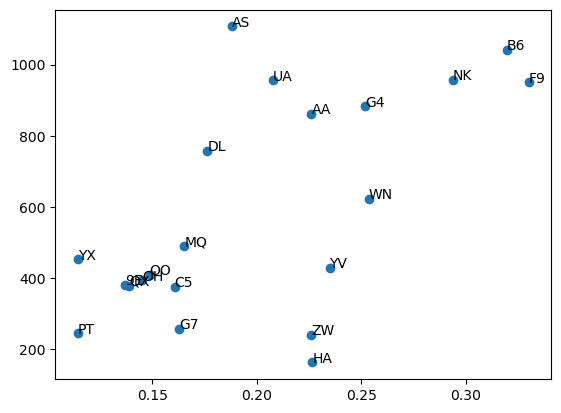

In [9]:
fig, ax = plt.subplots()
ax.scatter(x = carrier_delays, y = carrier_distances)

for i, txt in enumerate(carrier_delays.index):
    ax.annotate(txt, (carrier_delays["DEP_DEL15"][i], carrier_distances["DISTANCE"][i]))

* There are four groups in the scatterplot above, which we will use to encode the carriers.

In [10]:
# 0: PT, YX, 9E, QX, OH, OO, C5, G7, MQ
# 1: HA, ZW, YV, WN
# 2: DL, AA, G4, UA, AS
# 4: B6, F9, NK
df["OP_UNIQUE_CARRIER"].replace({"PT":0, "YX":0, "9E":0, "QX":0, "OH":0, "OO":0, "C5":0, "G7":0, "MQ":0, "HA":1, "ZW":1, "YV":1, "WN":1, "DL":2, "AA":2, "G4":2, "UA":2, "AS":2, "B6":4, "F9":4, "NK":4}, inplace = True)

## Train and Test Data:

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
model_X = df[['YEAR', 'MONTH', 'DAY_OF_MONTH', 'DEP_TIME', 'ARR_TIME', 'OP_UNIQUE_CARRIER', 'DISTANCE', 'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE', 'DEST_LATITUDE', 'DEST_LONGITUDE']]
model_y = df[['DEP_DEL15']]
X_train, X_test, y_train, y_test = train_test_split(model_X, model_y, test_size = 0.2, random_state = 50)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6254679, 11) (1563670, 11) (6254679, 1) (1563670, 1)
